In [1]:
import string
import random
import torch
import torch.nn as nn
import matplotlib.pyplot as plt

#### Prepare for Dataset

In [2]:
all_chars       = string.printable
n_chars         = len(all_chars)
file            = open('./shakespeare.txt').read()
file_len        = len(file)

print('Length of file: {}'.format(file_len))
print('All possible characters: {}'.format(all_chars))
print('Number of all possible characters: {}'.format(n_chars))

Length of file: 1115394
All possible characters: 0123456789abcdefghijklmnopqrstuvwxyzABCDEFGHIJKLMNOPQRSTUVWXYZ!"#$%&'()*+,-./:;<=>?@[\]^_`{|}~ 	

Number of all possible characters: 100


In [3]:
# Get a random sequence of the Shakespeare dataset.
def get_random_seq():
    seq_len     = 128  # The length of an input sequence.
    start_index = random.randint(0, file_len - seq_len)
    end_index   = start_index + seq_len + 1
    return file[start_index:end_index]

# Convert the sequence to one-hot tensor.
def seq_to_onehot(seq):
    tensor = torch.zeros(len(seq), 1, n_chars) 
    # Shape of the tensor:
    #     (sequence length, batch size, classes)
    # Here we use batch size = 1 and classes = number of unique characters.
    for t, char in enumerate(seq):
        index = all_chars.index(char)
        tensor[t][0][index] = 1
    return tensor

# Convert the sequence to index tensor.
def seq_to_index(seq):
    tensor = torch.zeros(len(seq), 1)
    # Shape of the tensor: 
    #     (sequence length, batch size).
    # Here we use batch size = 1.
    for t, char in enumerate(seq):
        tensor[t] = all_chars.index(char)
    return tensor

# Sample a mini-batch including input tensor and target tensor.
def get_input_and_target():
    seq    = get_random_seq()
    input  = seq_to_onehot(seq[:-1])      # Input is represented in one-hot.
    target = seq_to_index(seq[1:]).long() # Target is represented in index.
    return input, target

#### Choose a Device

In [4]:
# If there are GPUs, choose the first one for computing. Otherwise use CPU.
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)  
# If 'cuda:0' is printed, it means GPU is available.

cuda:0


#### Network Definition

In [5]:
class Net(nn.Module):
    def __init__(self):
        # Initialization.
        super(Net, self).__init__()
        self.input_size  = n_chars   # Input size: Number of unique chars.
        self.hidden_size = 100       # Hidden size: 100.
        self.output_size = n_chars   # Output size: Number of unique chars.

        self.func1 = nn.LSTM(self.input_size, self.hidden_size) ##, batch_first = True, bidirectional = True)
        self.func2 = nn.Linear(self.hidden_size, self.output_size)

        ###### To be filled ######
        ###### To be filled ######
    
    def forward(self, input, hidden, context):
        """ Forward function.
              input:  One-hot input. It refers to the x_t in homework write-up.
              hidden: Previous hidden state. It refers to the h_{t-1}.
            Returns (output, hidden) where output refers to y_t and 
                     hidden refers to h_t.
        """
        # Forward function.
        
        input = input.unsqueeze(0)
#         print("hidden:")
#         print(hidden)
#         print(hidden.shape)
        hidden = hidden.unsqueeze(0)
        context = context.unsqueeze(0)
        
#         print(hidden.shape)
#         print(context.shape)
#         print(input.shape)
#         print("after")
#         print (hidden.shape)
        output, (hidden, context) = self.func1(input, (hidden, context))
#         print (hidden.shape)
        output = self.func2(hidden)###### To be filled ######

        output = output.squeeze(0)
        hidden = hidden.squeeze(0)
        return output, hidden

    def init_hidden(self):
        # Initial hidden state.
        # 1 means batch size = 1.
        return torch.zeros(1, self.hidden_size).to(device), torch.zeros(1, self.hidden_size).to(device) 
    
net = Net()     # Create the network instance.
net.to(device)  # Move the network parameters to the specified device.

Net(
  (func1): LSTM(100, 100)
  (func2): Linear(in_features=100, out_features=100, bias=True)
)

#### Training Step and Evaluation Step

In [6]:
# Training step function.
def train_step(net, opt, input, target):
    """ Training step.
        net:    The network instance.
        opt:    The optimizer instance.
        input:  Input tensor.  Shape: [seq_len, 1, n_chars].
        target: Target tensor. Shape: [seq_len, 1].
    """
    seq_len = input.shape[0]    # Get the sequence length of current input.
    hidden, context = net.init_hidden()  # Initial hidden state.
    net.zero_grad()             # Clear the gradient.
    loss = 0                    # Initial loss.

    for t in range(seq_len):    # For each one in the input sequence.
        output, hidden = net(input[t], hidden, context)
#         print("output: ")
#         print(output.shape)
#         print("target:")
#         print(target[t].shape)
        loss += loss_func(output, target[t])

    loss.backward()             # Backward. 
    opt.step()                  # Update the weights.

    return loss / seq_len       # Return the average loss w.r.t sequence length.

In [7]:
# Evaluation step function.
def eval_step(net, init_seq='W', predicted_len=100):
    # Initialize the hidden state, input and the predicted sequence.
    hidden, context        = net.init_hidden()
    init_input    = seq_to_onehot(init_seq).to(device)
    predicted_seq = init_seq

    # Use initial string to "build up" hidden state.
    for t in range(len(init_seq) - 1):
        output, hidden = net(init_input[t], hidden, context)
        
    # Set current input as the last character of the initial string.
    input = init_input[-1]
    
    # Predict more characters after the initial string.
    for t in range(predicted_len):
        # Get the current output and hidden state.
        output, hidden = net(input, hidden, context)
        
        # Sample from the output as a multinomial distribution.
        predicted_index = torch.multinomial(output.view(-1).exp(), 1)[0]
        
        # Add predicted character to the sequence and use it as next input.
        predicted_char  = all_chars[predicted_index]
        predicted_seq  += predicted_char
        
        # Use the predicted character to generate the input of next round.
        input = seq_to_onehot(predicted_char)[0].to(device)

    return predicted_seq

#### Training Procedure

In [8]:
# Number of iterations.
iters       = 14100  # Number of training iterations.
print_iters = 100    # Number of iterations for each log printing.

# The loss variables.
all_losses = []
loss_sum   = 0

# Initialize the optimizer and the loss function.
opt       = torch.optim.Adam(net.parameters(), lr=0.005)
loss_func = nn.CrossEntropyLoss()

# Training procedure.
for i in range(iters):
    input, target = get_input_and_target()            # Fetch input and target.
    input, target = input.to(device), target.to(device) # Move to GPU memory.
    loss      = train_step(net, opt, input, target)   # Calculate the loss.
    loss_sum += loss                                  # Accumulate the loss.

    # Print the log.
    if i % print_iters == print_iters - 1:
        print('iter:{}/{} loss:{}'.format(i, iters, loss_sum / print_iters))
        print('generated sequence: {}\n'.format(eval_step(net)))
              
        # Track the loss.
        all_losses.append(loss_sum / print_iters)
        loss_sum = 0

iter:99/14100 loss:3.3774263858795166
generated sequence: WKM,e er psaah umte oo elhtnedrPjrirewua id nottGsnenetharnlsisgeet
lbl
ga
nneh np
.lmn,dyhre eodhoar

iter:199/14100 loss:2.8039867877960205
generated sequence: Wladre an snrt binne thaoald yet rsagsand:
Hl.
A, aon id aul t rnehit milrruy ininushetvercrr mey yea

iter:299/14100 loss:2.458989143371582
generated sequence: Waks aespy dom'rsa finh wid, s uo geoy umis, velistae.
The in qo in touveng? 
do cene sacfirceinldeti

iter:399/14100 loss:2.3872737884521484
generated sequence: WORD EECHHGISUSHEUCINESNDTHA
AUTAAMECISTDIA:
QSlryouroro, yot Kat pofev puaf brine gatFWalg harghe ci

iter:499/14100 loss:2.293800115585327
generated sequence: W;uris brourese hos
Al her frare fored, fomacd, y iw be y ando yof heaet' he heord you wor niwh fotha

iter:599/14100 loss:2.2585322856903076
generated sequence: Whaunfin, ha A saty
And your me sneface, an sild pe lus lathir, li tallllt.

A+HIORE:
Whereett I ther

iter:699/14100 loss:2.173485279

#### Training Loss Curve

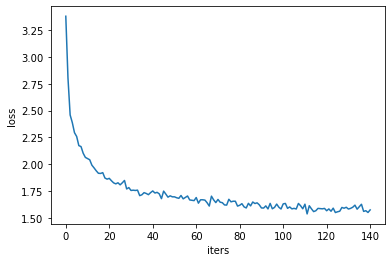

In [9]:
plt.xlabel('iters')
plt.ylabel('loss')
plt.plot(all_losses)
plt.show()

#### Evaluation: A Sample of Generated Sequence

In [10]:
print(eval_step(net, predicted_len=600))

We negrancence: Rosamons, what the telvens, by York, to houses of belass with thee thou not butring, fortune
Af your youndess tongue
such, with a come
Would priciuing frants, whose dive as consuints,
Brat milk, havil buster honeallm's diseacrs i' the gastes have a king'd you: must lark himself, on the expurbity.

Servant:
O, her Rome, sir,
And eyes,
And ambrackion, death,
Which we avon thee.

MIRANDA:
For the
son;
Hark from God's deceagn ciseooder best common!

Provost:
to refenus to bloody crowns at minsel, know o' the sense, we
Ahay and lie hatch'd moved to know
O down, it shall and
Griel?

M


In [11]:
import numpy as np
f = open("rnn_LSTM.npy", "w")
a = [data.item() for data in all_losses]

In [12]:
np.save("rnn_LSTM.npy", a)

In [13]:
np.load("rnn_LSTM.npy")

array([3.37742639, 2.80398679, 2.45898914, 2.38727379, 2.29380012,
       2.25853229, 2.17348528, 2.16467285, 2.10255313, 2.06403351,
       2.05248213, 2.04204583, 1.99167979, 1.96638238, 1.93932593,
       1.91617537, 1.91466331, 1.92194915, 1.8720839 , 1.8616029 ,
       1.86883903, 1.84659743, 1.82701468, 1.81775117, 1.82775629,
       1.80860925, 1.82755196, 1.84951651, 1.7702589 , 1.78303373,
       1.75630748, 1.75884902, 1.75625372, 1.75927782, 1.70807731,
       1.71607399, 1.73588526, 1.72836804, 1.71719062, 1.73608756,
       1.75180173, 1.73238862, 1.73882723, 1.72459626, 1.67999601,
       1.74998379, 1.72284269, 1.69391394, 1.70641518, 1.6970439 ,
       1.69695401, 1.68847406, 1.68317175, 1.70944571, 1.67819786,
       1.69138038, 1.70464718, 1.66811275, 1.66530252, 1.66170526,
       1.69061339, 1.63806367, 1.6695106 , 1.66954827, 1.66642737,
       1.64192641, 1.61128092, 1.70320451, 1.66902065, 1.64336538,
       1.67258394, 1.64697397, 1.64262962, 1.62162232, 1.62015

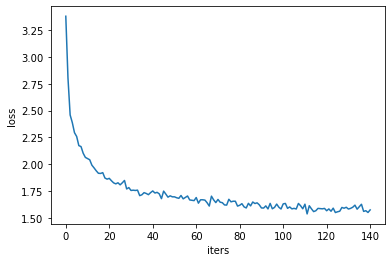

In [14]:
plt.xlabel('iters')
plt.ylabel('loss')
plt.plot(np.load("rnn_LSTM.npy"))
plt.show()

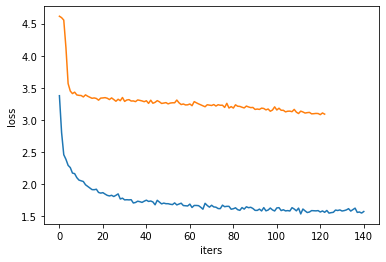

In [18]:
plt.xlabel('iters')
plt.ylabel('loss')
plt.plot(np.load("rnn_LSTM.npy"))
plt.plot(np.load("original_RNN.npy"))
plt.show()